# LunarLander-v2 solver
## 1. Functions and classes
Import packages, set up the network and training functions

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import random
import numpy as np
import gym
import gym.spaces as sp
from tqdm import trange
from time import sleep
from collections import namedtuple, deque
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#%% Policy network
class QNet(nn.Module):
    # Policy Network
    def __init__(self, n_states, n_actions, n_hidden=64):
        super(QNet, self).__init__()

        self.fc = nn.Sequential(
            nn.Linear(n_states, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_actions)
            )

    def forward(self, x):
        return self.fc(x)

#%% dqn    
class DQN():
    def __init__(self, n_states, n_actions, batch_size=64, lr=1e-4, gamma=0.99, mem_size=int(1e5), learn_step=5, tau=1e-3):
        self.n_states = n_states
        self.n_actions = n_actions
        self.batch_size = batch_size
        self.gamma = gamma
        self.learn_step = learn_step
        self.tau = tau

        # model
        self.net_eval = QNet(n_states, n_actions).to(device)
        self.net_target = QNet(n_states, n_actions).to(device)
        self.optimizer = optim.Adam(self.net_eval.parameters(), lr=lr)
        self.criterion = nn.MSELoss()

        # memory
        self.memory = ReplayBuffer(n_actions, mem_size, batch_size)
        self.counter = 0    # update cycle counter

    def getAction(self, state, epsilon):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)

        self.net_eval.eval()
        with torch.no_grad():
            action_values = self.net_eval(state)
        self.net_eval.train()

        # epsilon-greedy
        if random.random() < epsilon:
            action = random.choice(np.arange(self.n_actions))
        else:
            action = np.argmax(action_values.cpu().data.numpy())

        return action

    def save2memory(self, state, action, reward, next_state, done):
        self.memory.add(state, action, reward, next_state, done)

        self.counter += 1
        if self.counter % self.learn_step == 0:
            if len(self.memory) >= self.batch_size:
                experiences = self.memory.sample()
                self.learn(experiences)

    def learn(self, experiences):
        states, actions, rewards, next_states, dones = experiences

        q_target = self.net_target(next_states).detach().max(axis=1)[0].unsqueeze(1)
        y_j = rewards + self.gamma * q_target * (1 - dones)          # target, if terminal then y_j = rewards
        q_eval = self.net_eval(states).gather(1, actions)

        # loss backprop
        loss = self.criterion(q_eval, y_j)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # soft update target network
        self.softUpdate()

    def softUpdate(self):
        for eval_param, target_param in zip(self.net_eval.parameters(), self.net_target.parameters()):
            target_param.data.copy_(self.tau*eval_param.data + (1.0-self.tau)*target_param.data)


class ReplayBuffer():
    def __init__(self, n_actions, memory_size, batch_size):
        self.n_actions = n_actions
        self.batch_size = batch_size
        self.memory = deque(maxlen = memory_size)
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

    def __len__(self):
        return len(self.memory)

    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)
    
#%% train
def train(env, agent, n_episodes=2000, max_steps=1000, eps_start=1.0, eps_end=0.1, eps_decay=0.995, target=200):
    score_hist = []
    epsilon = eps_start

    bar_format = '{l_bar}{bar:10}| {n:4}/{total_fmt} [{elapsed:>7}<{remaining:>7}, {rate_fmt}{postfix}]'
    # bar_format = '{l_bar}{bar:10}{r_bar}'
    pbar = trange(n_episodes, unit="ep", bar_format=bar_format, ascii=True)
    for idx_epi in pbar:
        state = env.reset()
        score = 0
        for idx_step in range(max_steps):
            action = agent.getAction(state, epsilon)
            next_state, reward, done, _ = env.step(action)
            agent.save2memory(state, action, reward, next_state, done)
            state = next_state
            score += reward

            if done:
                break

        score_hist.append(score)
        score_avg = np.mean(score_hist[-100:])
        epsilon = max(eps_end, epsilon*eps_decay)

        pbar.set_postfix_str(f"Score: {score: 7.2f}, 100 score avg: {score_avg: 7.2f}")
        pbar.update(0)

        # if (idx_epi+1) % 100 == 0:
        #     print(" ")
        #     sleep(0.1)

        # Early stop
        if len(score_hist) >= 100:
            if score_avg >= target:
                break

    if (idx_epi+1) < n_episodes:
        print("\nTarget Reached!")
    else:
        print("\nDone!")
    # torch.save(agent.net_eval.state_dict(), 'checkpoint.pth')

    return score_hist

#%% Test Lunar Lander
def testLander(env, agent, loop=3):
    for i in range(loop):
        state = env.reset()
        for idx_step in range(500):
            action = agent.getAction(state, epsilon=0)
            env.render()
            state, reward, done, _ = env.step(action)
            if done:
                break
    env.close()
    
def plotScore(scores):
    plt.figure()
    plt.plot(scores)
    plt.title("Score History")
    plt.xlabel("Episodes")
    plt.show()

ModuleNotFoundError: No module named 'gym'

## 2. Training Parameters

 51%|#####1    | 2561/5000 [  21:52<  20:50,  1.95ep/s, Score:  256.92, 100 score avg:  250.19]


Target Reached!


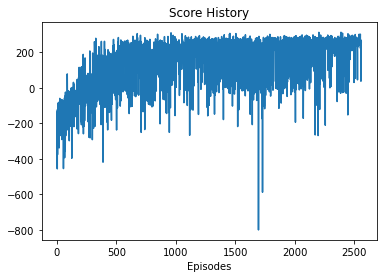

In [ ]:
BATCH_SIZE = 128
LR = 5e-4
EPISODES = 5000
TARGET_SCORE = 250.     # early training stop at avg score
GAMMA = 0.99            # discount factor
MEMORY_SIZE = 10000     # max memory buffer size
LEARN_STEP = 5          # how often to learn
TAU = 1e-3              # for soft update of target parameters

## 3. Train the network

In [ ]:
env2 = gym.make('LunarLander-v2')
num_states = env2.observation_space.shape[0]
num_actions = env2.action_space.n
agent2 = DQN(
    n_states = num_states,
    n_actions = num_actions,
    batch_size = BATCH_SIZE,
    lr = LR,
    gamma = GAMMA,
    mem_size = MEMORY_SIZE,
    learn_step = LEARN_STEP,
    tau = TAU
    )
score_hist2 = train(env2, agent2, n_episodes=EPISODES, target=TARGET_SCORE)
plotScore(score_hist2)

if str(device) == "cuda":
    torch.cuda.empty_cache()

## 4. Test the LunarLander!

Demo gif:  
![demo_gif](https://imgur.com/X6MNZLT.gif)

Run code below to test trained result

In [ ]:
testLander(env2, agent2, loop=10)

## Testing results
### (a) Compare total return curves

| finite_MDP_env | LunarLander-v2 |
|:--:|:--:|
| ![finite curve](https://imgur.com/48yYxO7.png) | ![lander curve](https://imgur.com/f7C5KYp.png) |

Although the training curve is not clear in finite_MDP_env, we can still see an upwards trend and convergence in both score curves.

### (b) Tune Parameters

#### Target score

I implemented an early stop function which, when the average of the last 100 scores reach a target value, will stop the training process and plot the result. I find that the target score of 250 usually produces more consistent landings and higher total rewards.  
Setting the target score to a lower value like 200, will result in more misses in the final demo. Setting the target score too high, however, will sometimes result in the average score never reaching the target value, which takes more time to train and will not necessarily produce a better result.

| $Target=200, \gamma=0.99$ | $Target=250, \gamma=0.99$ |
|:--:|:--:|
|![t200](https://imgur.com/TJnDOsg.gif)|![t250](https://imgur.com/X6MNZLT.gif)|  

#### Discount factor

The discount factor $\gamma$ determines the importance of future rewards, and the value should be $0\le\gamma<1$.  
Setting it too low will make it "short-sighted", only consider rewards nearest to its state. Setting it higher will make it consider more long-term rewards.  
If the discount factor is set equal to or greater than 1, it may cause $V_\pi$ and $Q_\pi$ to diverge.

Experiments as below:

|| $Target=230, \gamma=0.9$ | $Target=230, \gamma=1.3$ |
|:--|:--:|:--:|
|Training Time| 2:02:58, 5000 episodes | 12:09, 5000 episodes |
|Training curve|![g09_curve](https://imgur.com/EwEbKGm.png)|![g13_curve](https://imgur.com/O6PxjCe.png)|  
|Result| ![g09_gif](https://imgur.com/IP599Gu.gif) | ![g13_gif](https://imgur.com/sO5UAC6.gif) |

We can see that, $\gamma$ set to suboptimal values will result in slow training time and no convergence, and cause the ship to continue hovering and not land.  
$\gamma$ set to greater than 1 will also cause it to fail to converge, and the ship only fired one side rocket and flew out of control.